# Prisoner's Dilemma Graph Visualization

This notebook visualizes the LangGraph structure for the Prisoner's Dilemma game with parallel agent execution.

In [2]:
from langchain_ollama.llms import OllamaLLM
from langgraph.graph import START, END, StateGraph, MessagesState
from typing import TypedDict
from langgraph.checkpoint.memory import InMemorySaver
from prompt import game_prompt, good_player_prompt, bad_player_prompt
import json
from operator import add
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

In [4]:
# model setup
model = "mistral:latest"
llm = OllamaLLM(model=model)

#memory setup
checkpointer = InMemorySaver()
config = { "configurable": { "thread_id": "1" } }

In [5]:
# subgraph state setup
class SubgraphState(TypedDict):
    agent_1_prompt: str
    agent_1_choice: list[str]
    agent_2_prompt: str
    agent_2_choice: list[str]

# subgraph nodes setup
def Agent1(state: SubgraphState):
    messages = llm.invoke(state["agent_1_prompt"])
    if isinstance(messages, str):
        response= json.loads(messages)
    return {"agent_1_choice": state["agent_1_choice"] + [response["agent_choice"]]}

def Agent2(state: SubgraphState):
    messages = llm.invoke(state["agent_2_prompt"])
    if isinstance(messages, str):
        response= json.loads(messages)
    return {"agent_2_choice": state["agent_2_choice"] + [response["agent_choice"]]}

In [6]:
# subgraph setup - PARALLEL EXECUTION
subgraph_builder = StateGraph(SubgraphState)
subgraph_builder.add_node("Agent1", Agent1)
subgraph_builder.add_node("Agent2", Agent2)
# adding parallel edges - both agents start simultaneously
subgraph_builder.add_edge(START, "Agent1")
subgraph_builder.add_edge(START, "Agent2")
subgraph_builder.add_edge("Agent1", END)
subgraph_builder.add_edge("Agent2", END)
subgraph = subgraph_builder.compile(checkpointer=checkpointer)

In [7]:
# graph state setup
class ParentState(MessagesState):
    agent_1_choice_parent : list[str]
    agent_2_choice_parent : list[str]
    
# graph node setup
def transform(state: ParentState):
    response = subgraph.invoke({
        "agent_1_choice": state["agent_1_choice_parent"], 
        "agent_2_choice": state["agent_2_choice_parent"], 
        "agent_1_prompt": good_player_prompt, 
        "agent_2_prompt": bad_player_prompt
    }, config=config)
    
    return {
        "agent_1_choice_parent": response["agent_1_choice"], 
        "agent_2_choice_parent": response["agent_2_choice"]
    }

graph_builder = StateGraph(ParentState)
graph_builder.add_node("transform", transform)
graph_builder.add_edge(START, "transform")
graph_builder.add_edge("transform", END)
graph = graph_builder.compile(checkpointer=checkpointer)

## Subgraph Visualization (Parallel Agent Execution)

=== SUBGRAPH VISUAL ===


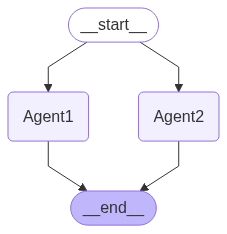

In [8]:
print("=== SUBGRAPH VISUAL ===")
display(Image(subgraph.get_graph().draw_mermaid_png()))

## Main Graph Visualization

=== MAIN GRAPH VISUAL ===


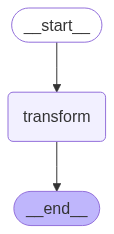

In [9]:
print("=== MAIN GRAPH VISUAL ===")
display(Image(graph.get_graph().draw_mermaid_png()))

## Run the Game

In [ ]:
# Run the game
def run_game():
    for event in graph.stream({
        "messages": [{"role": "user", "content": game_prompt}], 
        "agent_1_choice_parent": [], 
        "agent_2_choice_parent": []
    }, subgraphs=True, config=config):
        print(event)

run_game()

((), {'transform': {'agent_1_choice_parent': ['COOPERATE'], 'agent_2_choice_parent': ['DEFECT']}})
